
Running example of classification using GradientBoostedTrees

Test Error = 0.0384615384615
Learned classification ensemble model:
TreeEnsembleModel classifier with 30 trees

  Tree 0:
    If (feature 434 <= 0.0)
     Predict: -1.0
    Else (feature 434 > 0.0)
     Predict: 1.0
  Tree 1:
    If (feature 490 <= 31.0)
     If (feature 210 <= 227.0)
      Predict: -0.4768116880884702
     Else (feature 210 > 227.0)
      Predict: -0.4768116880884703
    Else (feature 490 > 31.0)
     If (feature 348 <= 29.0)
      If (feature 322 <= 234.0)
       Predict: 0.47681168808847024
      Else (feature 322 > 234.0)
       Predict: 0.47681168808847024
     Else (feature 348 > 29.0)
      Predict: 0.4768116880884712
  Tree 2:
    If (feature 434 <= 0.0)
     If (feature 215 <= 71.0)
      Predict: -0.4381935810427206
     Else (feature 215 > 71.0)
      Predict: -0.4381935810427206
    Else (feature 434 > 0.0)
     If (feature 320 <= 127.0)
      Predict: 0.4381935810427206
     Else (feature 320 >

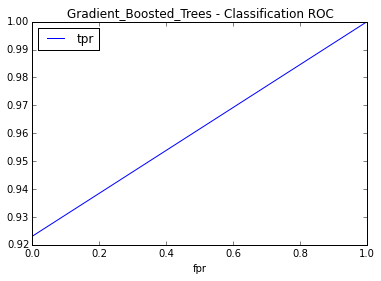

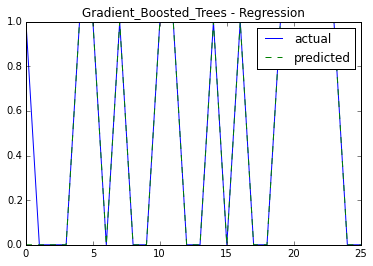

In [1]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from __future__ import print_function


import sys



import pandas
from pyspark.context import SparkContext

from pyspark.mllib.tree import GradientBoostedTrees

from pyspark.mllib.util import MLUtils
from pyspark.sql import SQLContext


from sklearn import metrics




def testClassification(trainingData, testData):
   
	# Train a GradientBoostedTrees model.
    
	#  Empty categoricalFeaturesInfo indicates all features are continuous.
  
	sqlContext = SQLContext(sc)
	
	model = GradientBoostedTrees.trainClassifier(trainingData,categoricalFeaturesInfo={},numIterations=30, maxDepth=4)

	# Evaluate model on test instances and compute test error
    
	predictions = model.predict(testData.map(lambda x: x.features))

	labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)

	predictedDataFrame = sqlContext.createDataFrame(labelsAndPredictions)
	

	# Creates data frame to plot ROC curve
	fpr, tpr, _ = metrics.roc_curve(predictedDataFrame.toPandas()['_1'].values, predictedDataFrame.toPandas()['_2'].values)
	
	
	df = pandas.DataFrame(dict(fpr=fpr, tpr=tpr))
	

	# ROC curve plot
	df.plot('fpr', 'tpr', title = 'Gradient_Boosted_Trees - Classification ROC')
	testErr = labelsAndPredictions.filter(lambda v_p: v_p[0] != v_p[1]).count()/ float(testData.count())

	print('Test Error = ' + str(testErr))

	print('Learned classification ensemble model:')

	print(model.toDebugString())
	



def testRegression(trainingData, testData):
	# Train a GradientBoostedTrees model.
	#  Empty categoricalFeaturesInfo indicates all features are continuous.

	model = GradientBoostedTrees.trainRegressor(trainingData, categoricalFeaturesInfo={},numIterations=30, maxDepth=4)

	# Evaluate model on test instances and compute test error
    
	predictions = model.predict(testData.map(lambda x: x.features))

	labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)

	predictedDataFrame = sqlContext.createDataFrame(labelsAndPredictions)	
	# Created data frame for visualization
	df = predictedDataFrame.toPandas()
	df.columns = ['actual', 'predicted']	
	# 'Line' plot is used here to differentiate 'actual' and 'predicted' values
	df.plot(style=['-','--'], title = 'Gradient_Boosted_Trees - Regression')
	testMSE = labelsAndPredictions.map(lambda vp: (vp[0] - vp[1]) * (vp[0] - vp[1])).sum()/ float(testData.count())

	print('Test Mean Squared Error = ' + str(testMSE))

	print('Learned regression ensemble model:')

	print(model.toDebugString())



	



# Load and parse the data file into an RDD of LabeledPoint.

data = MLUtils.loadLibSVMFile(sc, '/Data/Spark/MLLib/Sample_LibSVM_Data.txt')

# Split the data into training and test sets (30% held out for testing)

(trainingData, testData) = data.randomSplit([0.7, 0.3])



print('\nRunning example of classification using GradientBoostedTrees\n')

testClassification(trainingData, testData)



print('\nRunning example of regression using GradientBoostedTrees\n')

testRegression(trainingData, testData)


